<a href="https://colab.research.google.com/github/khairul746/IDCamp-ML-Engineer-2024-Projects/blob/main/Klasifikasi-Gambar/Klasifikasi_Gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Images Classification
Khairullah Ilyas \
Dicoding IDCamp 2024 : Intermediate Level Submission

## 1. Import Library

In [1]:
import kagglehub
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import zipfile
import os
import shutil
import os

from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback

## 2. Load Dataset

In [3]:
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [4]:
# Download dataset
!kaggle datasets download --force yessicatuteja/skycity-the-city-landscape-dataset

Dataset URL: https://www.kaggle.com/datasets/yessicatuteja/skycity-the-city-landscape-dataset
License(s): CC0-1.0
 97% 113M/117M [00:01<00:00, 106MB/s]
100% 117M/117M [00:01<00:00, 89.4MB/s]


In [5]:
# Ekstrak dataset
zip_path = 'skycity-the-city-landscape-dataset.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall()

In [6]:
# Path to the train directory
data_dir = "/content/Cityscape Dataset"

### 2.1. Images Count

In [7]:
def count_images(data_dir):
    class_counts = {}
    total_images = 0
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            image_count = len(os.listdir(class_path))
            class_counts[class_name] = image_count
            total_images += image_count
    return class_counts, total_images


class_counts, total_images = count_images(data_dir)

print("Jumlah gambar per kelas:")
for class_name, count in class_counts.items():
    print(f"- {class_name}: {count}")

print(f"\nTotal jumlah gambar: {total_images}")


Jumlah gambar per kelas:
- Commercial: 800
- Park: 800
- Parking: 800
- Industrial: 800
- Landmark: 800
- Stadium: 800
- Residential: 800
- Intersection: 800
- Bridge: 800
- Playground: 800

Total jumlah gambar: 8000


### 2.2. Image Resolutions Checking

In [8]:
# Dictionary to store image resolutions
image_resolutions = {}

# Counter to limit the number of images processed
image_count = 0
max_images = 10

# Iterate through each subfolder and image file
for subdir, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith(('jpg', 'jpeg', 'png')):
            file_path = os.path.join(subdir, file)
            with Image.open(file_path) as img:
                image_resolutions[file_path] = img.size
                image_count += 1
                if image_count >= max_images:
                    break

# Print the resolutions
for path, resolution in image_resolutions.items():
    print(f'{path}: {resolution}')

/content/Cityscape Dataset/Commercial/703.jpg: (256, 256)
/content/Cityscape Dataset/Commercial/239.jpg: (256, 256)
/content/Cityscape Dataset/Commercial/317.jpg: (256, 256)
/content/Cityscape Dataset/Commercial/215.jpg: (256, 256)
/content/Cityscape Dataset/Commercial/304.jpg: (256, 256)
/content/Cityscape Dataset/Commercial/754.jpg: (256, 256)
/content/Cityscape Dataset/Commercial/075.jpg: (256, 256)
/content/Cityscape Dataset/Commercial/569.jpg: (256, 256)
/content/Cityscape Dataset/Commercial/764.jpg: (256, 256)
/content/Cityscape Dataset/Commercial/210.jpg: (256, 256)
/content/Cityscape Dataset/Park/703.jpg: (256, 256)
/content/Cityscape Dataset/Parking/703.jpg: (256, 256)
/content/Cityscape Dataset/Industrial/703.jpg: (256, 256)
/content/Cityscape Dataset/Landmark/703.jpg: (256, 256)
/content/Cityscape Dataset/Stadium/703.jpg: (256, 256)
/content/Cityscape Dataset/Residential/703.jpg: (256, 256)
/content/Cityscape Dataset/Intersection/703.jpg: (256, 256)
/content/Cityscape Datase

## 3. Augmentasi Gambar dan Pemisahan Data

### 3.1. Train test split

In [9]:
# Path to the dataset
train_dir = "data/train"
test_dir = "data/test"

# Making new directory for saving divided data
for folder in [train_dir, test_dir]:
    for class_name in os.listdir(data_dir):
        os.makedirs(os.path.join(folder, class_name), exist_ok=True)

In [10]:
# Taking images list for each class
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    images = os.listdir(class_path)

    train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)  # 80% Train, 20% Test
    # Copy images to the new directory
    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    for img in test_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(test_dir, class_name, img))


### 3.2. Augmentasi Gambar

In [11]:
# Create an ImageDataGenerator for training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Create a generator for the training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Create a generator for the validation data
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 5120 images belonging to 10 classes.
Found 1280 images belonging to 10 classes.


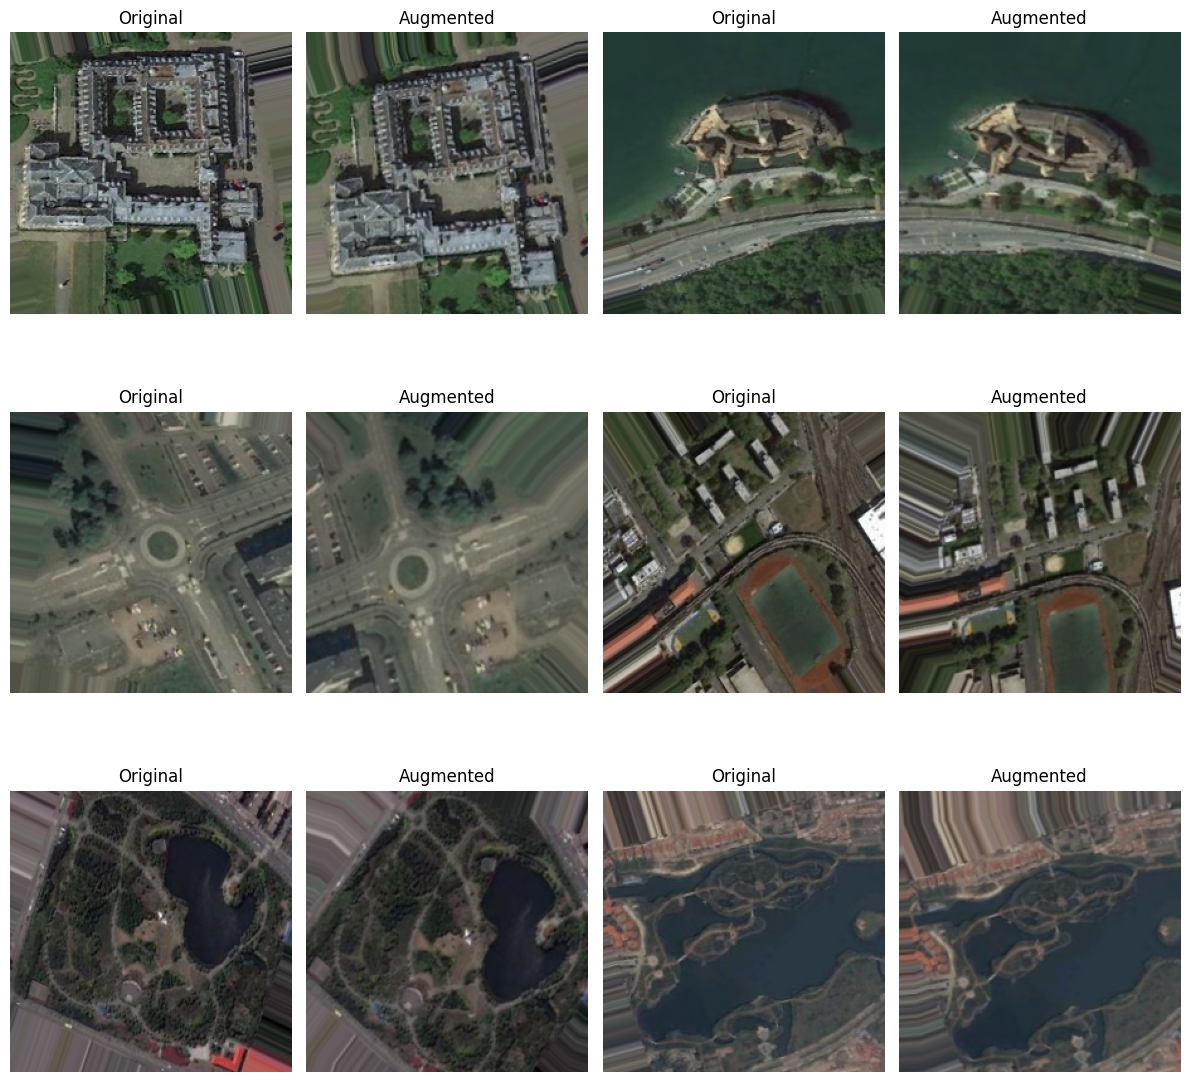

In [12]:
# Ambil batch gambar dari train_generator
images, labels = next(train_generator)

# Tampilkan beberapa gambar asli dan hasil augmentasi
plt.figure(figsize=(12, 12))
for i in range(6):
    plt.subplot(3, 4, 2*i+1)
    plt.imshow(images[i])
    plt.title('Original')
    plt.axis('off')

    # Augmentasi gambar
    augmented_image = train_datagen.random_transform(images[i])
    plt.subplot(3, 4, 2*i+2)
    plt.imshow(augmented_image)
    plt.title('Augmented')
    plt.axis('off')

plt.tight_layout()
plt.show()

## 4. Model Development

In [19]:
tf.keras.backend.clear_session

<function keras.src.backend.common.global_state.clear_session(free_memory=True)>

In [13]:
class StopTrainingCallback(Callback):
    def __init__(self, patience=3):
        super(StopTrainingCallback, self).__init__()
        self.patience = patience
        self.best_val_loss = float('inf')
        self.wait = 0

    def on_epoch_end(self, epoch, logs={}):
        if logs.get("accuracy") >= 0.95:
            print("\n Akurasi 95% tercapai. Proses train dihentikan...\n")
            self.model.stop_training = True
            return

        current_val_loss = logs.get("val_loss")
        if current_val_loss < self.best_val_loss:
            self.best_val_loss = current_val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"\n Tidak ada penurunan nilai loss validasi setelah {self.patience} epochs. Proses train dihentikan...\n")
                self.model.stop_training = True

In [20]:
class PlotPerIteration(tf.keras.callbacks.Callback):
    def __init__(self, interval=100):
        self.interval = interval
        self.losses = []
        self.val_losses = []
        self.accuracies = []
        self.val_accuracies = []
        self.iterations = 0
        self.epochs = 0

    def on_batch_end(self, batch, logs=None):
        self.iterations += 1
        if self.iterations % self.interval == 0:
            loss = logs.get('loss')
            accuracy = logs.get('accuracy')
            if loss is not None:
                self.losses.append(loss)
            if accuracy is not None:
                self.accuracies.append(accuracy)

    def on_epoch_end(self, epoch, logs=None):
        self.epochs += 1
        val_loss = logs.get('val_loss')
        val_accuracy = logs.get('val_accuracy')
        if val_loss is not None:
            self.val_losses.append(val_loss)
        if val_accuracy is not None:
            self.val_accuracies.append(val_accuracy)
        self.plot_metrics()

    def plot_metrics(self):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.plot(range(0, len(self.accuracies)*self.interval, self.interval), self.accuracies, label='Train')
        plt.plot(
            np.linspace(
                len(self.accuracies) * self.interval / len(self.val_accuracies),
                len(self.accuracies) * self.interval,
                int(len(self.val_accuracies))
                ),
            self.val_accuracies, label='Validation')
        plt.title('Model Accuracy (per iteration)')
        plt.ylabel('Accuracy')
        plt.xlabel('Iteration')
        locator = plt.AutoLocator()
        formatter = plt.FormatStrFormatter('%d')
        plt.gca().xaxis.set_major_locator(locator)
        plt.gca().xaxis.set_major_formatter(formatter)
        plt.grid()
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.subplot(1, 2, 2)
        plt.plot(range(0, len(self.losses)*self.interval, self.interval), self.losses, label='Train')
        plt.plot(
            np.linspace(
                len(self.losses) * self.interval / len(self.val_losses),
                len(self.losses) * self.interval,
                int(len(self.val_losses))
                ),
            self.val_losses, label='Validation')
        plt.title('Model Loss (per iteration)')
        plt.ylabel('Loss')
        plt.xlabel('Iteration')
        locator = plt.AutoLocator()
        formatter = plt.FormatStrFormatter('%d')
        plt.gca().xaxis.set_major_locator(locator)
        plt.gca().xaxis.set_major_formatter(formatter)
        plt.grid()
        plt.legend(['Train', 'Validation'], loc='upper left')

        plt.tight_layout()
        plt.show()

plot_callback = PlotPerIteration(interval=40)

In [21]:
model = Sequential()
model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.1065 - loss: 2.3002

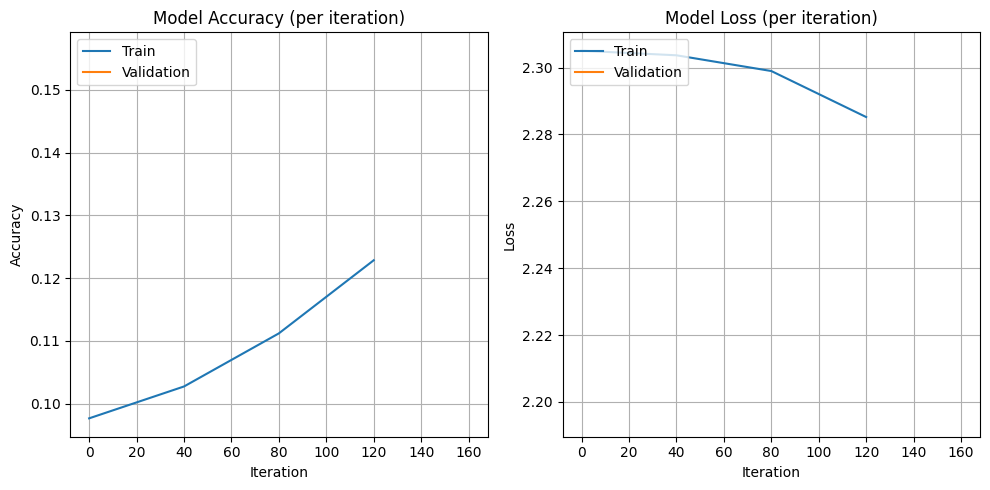

160/160 ━━━━━━━━━━━━━━━━━━━━ 130s 622ms/step - accuracy: 0.1066 - loss: 2.3001 - val_accuracy: 0.1562 - val_loss: 2.1951
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.2641 - loss: 2.0014

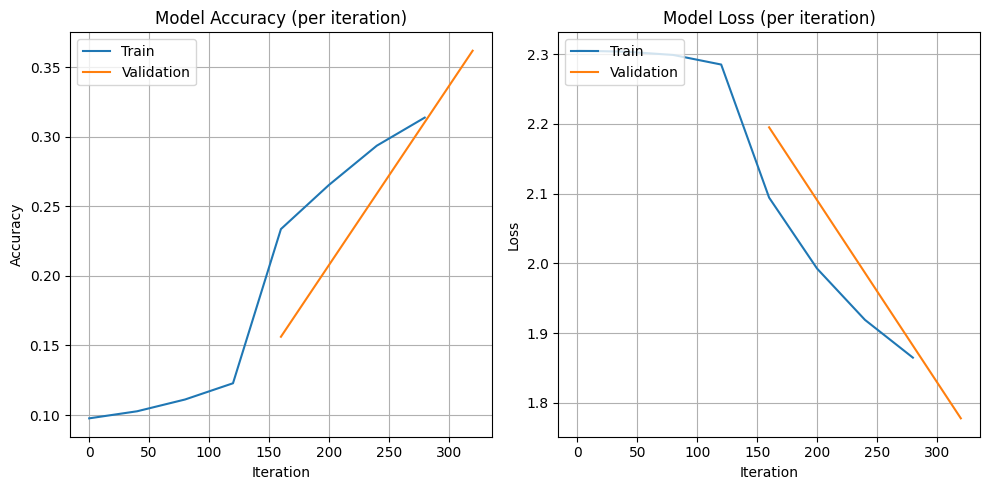

160/160 ━━━━━━━━━━━━━━━━━━━━ 88s 552ms/step - accuracy: 0.2645 - loss: 2.0005 - val_accuracy: 0.3617 - val_loss: 1.7776
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.3980 - loss: 1.6292

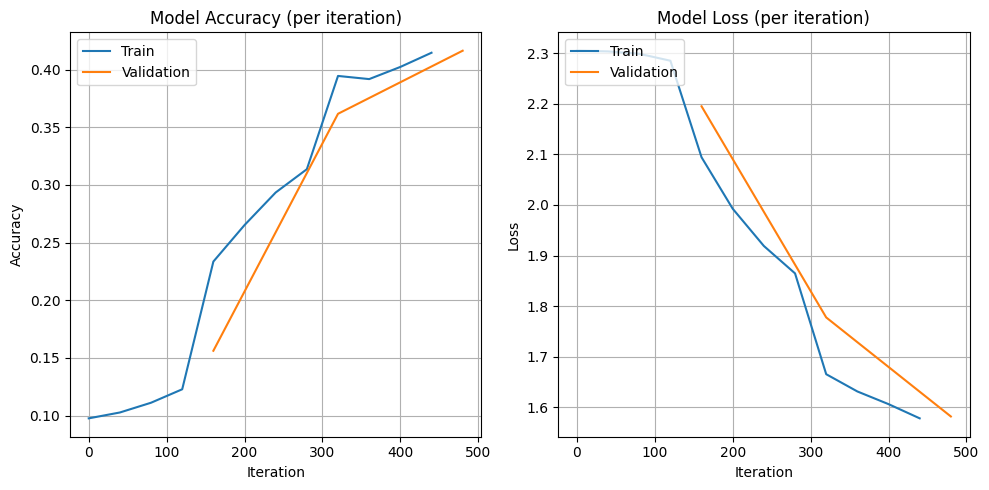

160/160 ━━━━━━━━━━━━━━━━━━━━ 88s 547ms/step - accuracy: 0.3981 - loss: 1.6289 - val_accuracy: 0.4164 - val_loss: 1.5818
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.4456 - loss: 1.5522

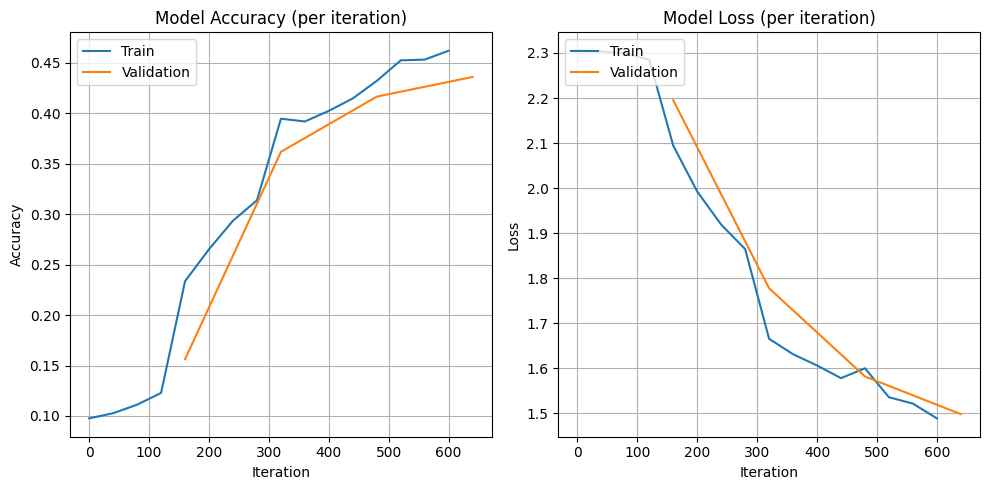

160/160 ━━━━━━━━━━━━━━━━━━━━ 147s 580ms/step - accuracy: 0.4457 - loss: 1.5518 - val_accuracy: 0.4359 - val_loss: 1.4982
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.4930 - loss: 1.4245

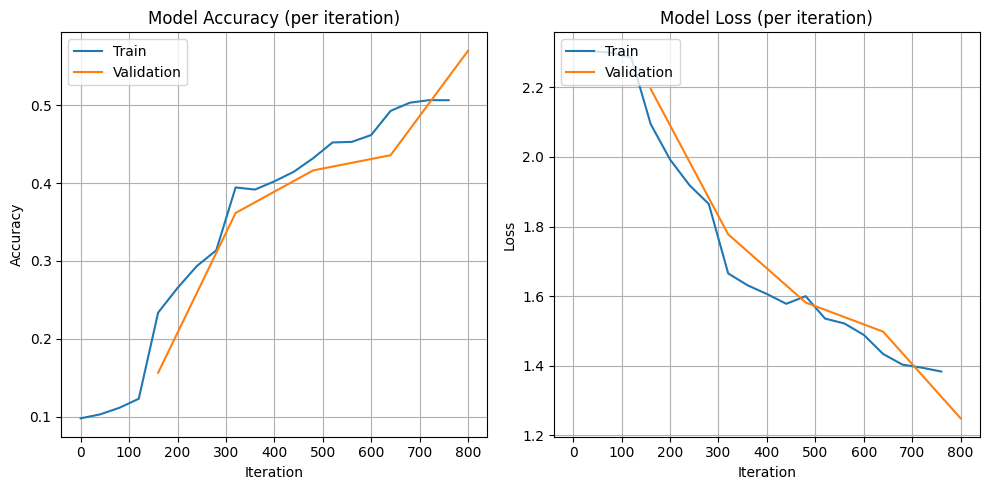

160/160 ━━━━━━━━━━━━━━━━━━━━ 93s 582ms/step - accuracy: 0.4931 - loss: 1.4243 - val_accuracy: 0.5703 - val_loss: 1.2491
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.5349 - loss: 1.2857

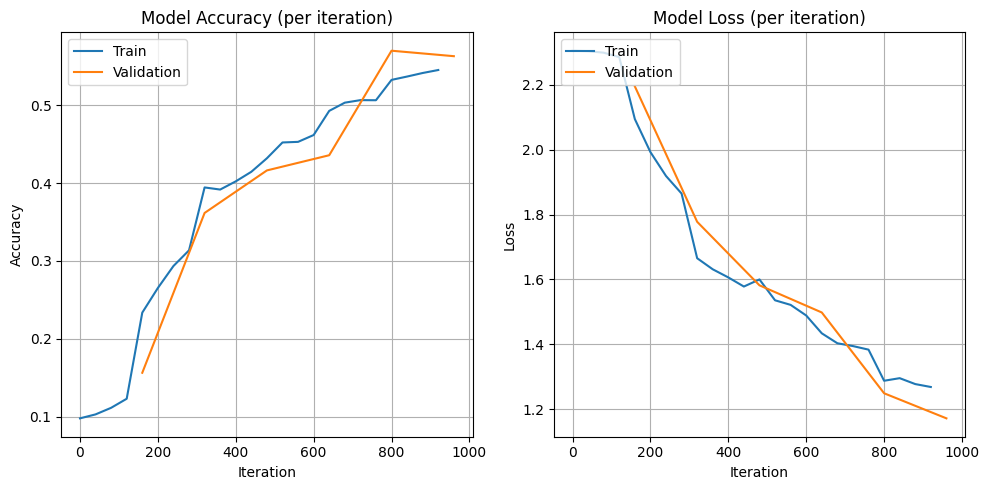

160/160 ━━━━━━━━━━━━━━━━━━━━ 143s 588ms/step - accuracy: 0.5350 - loss: 1.2855 - val_accuracy: 0.5633 - val_loss: 1.1718
Epoch 7/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.5762 - loss: 1.2235

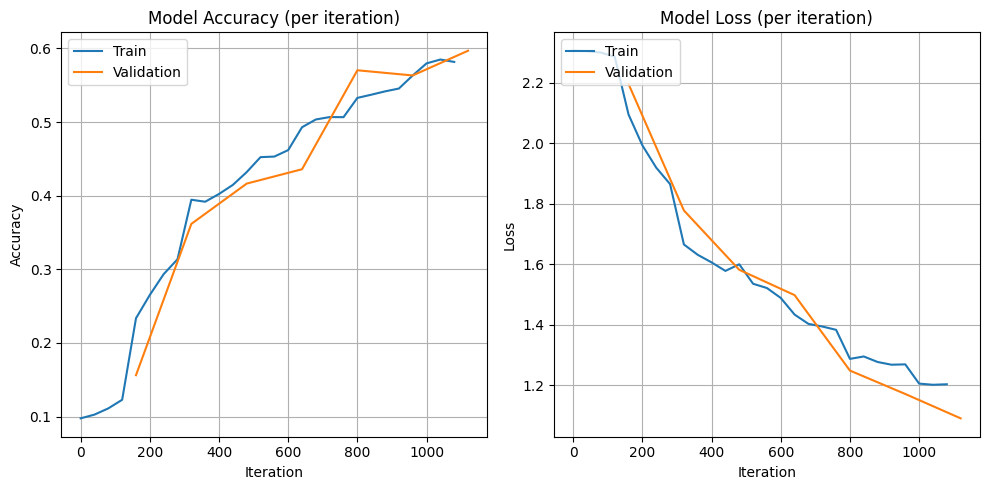

160/160 ━━━━━━━━━━━━━━━━━━━━ 88s 549ms/step - accuracy: 0.5762 - loss: 1.2234 - val_accuracy: 0.5969 - val_loss: 1.0914
Epoch 8/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.5876 - loss: 1.1351

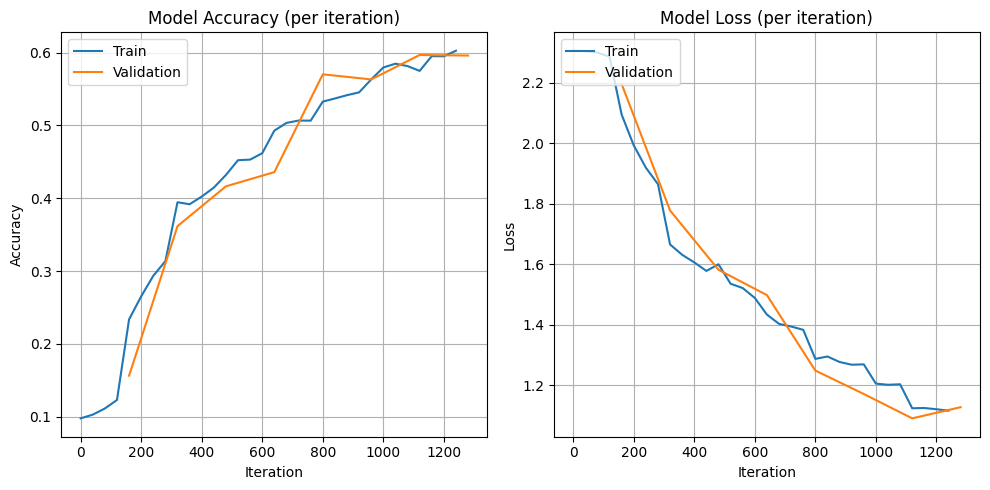

160/160 ━━━━━━━━━━━━━━━━━━━━ 88s 547ms/step - accuracy: 0.5877 - loss: 1.1350 - val_accuracy: 0.5961 - val_loss: 1.1283
Epoch 9/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.6217 - loss: 1.0622

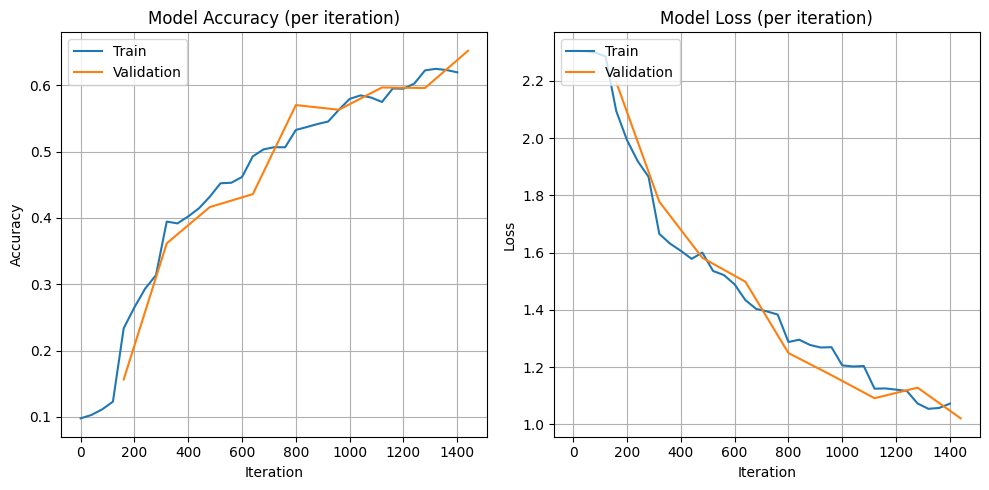

160/160 ━━━━━━━━━━━━━━━━━━━━ 88s 549ms/step - accuracy: 0.6217 - loss: 1.0622 - val_accuracy: 0.6523 - val_loss: 1.0211
Epoch 10/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.6459 - loss: 1.0154

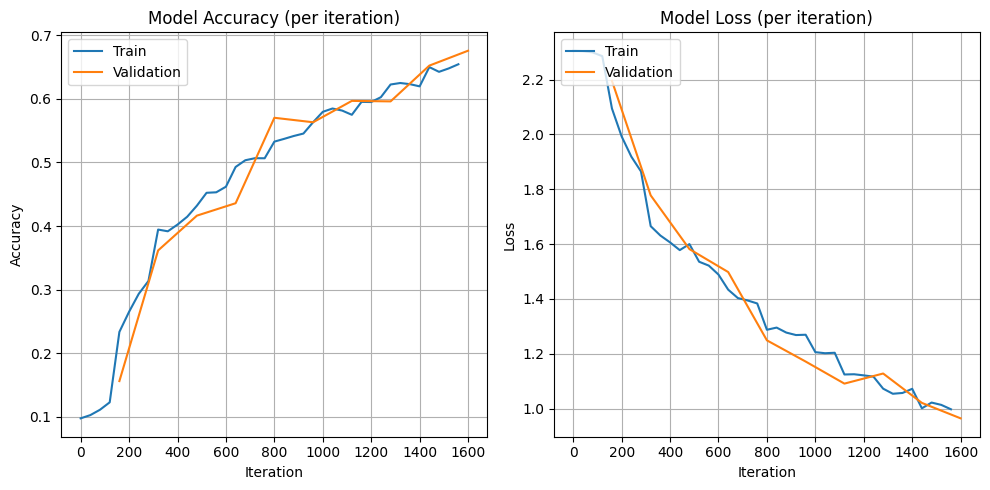

160/160 ━━━━━━━━━━━━━━━━━━━━ 143s 553ms/step - accuracy: 0.6460 - loss: 1.0153 - val_accuracy: 0.6758 - val_loss: 0.9648
Epoch 11/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.6674 - loss: 0.9626

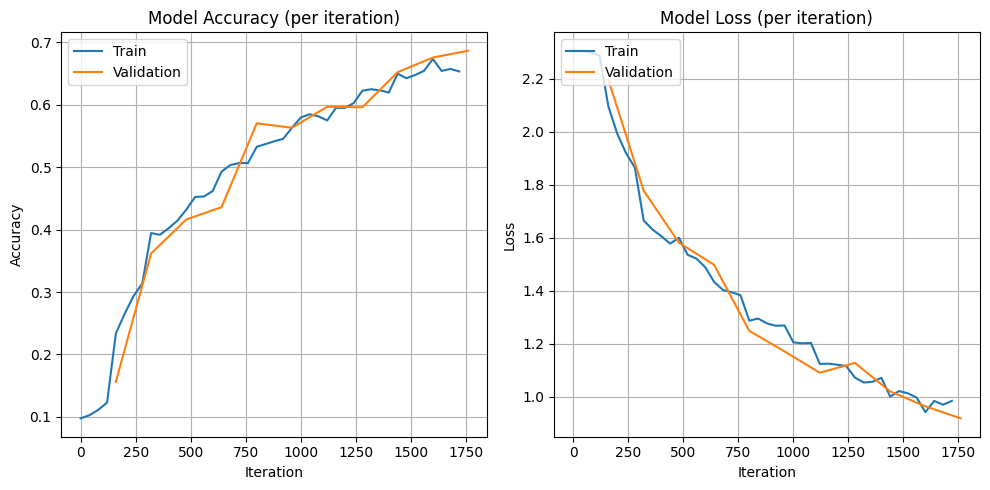

160/160 ━━━━━━━━━━━━━━━━━━━━ 142s 553ms/step - accuracy: 0.6673 - loss: 0.9628 - val_accuracy: 0.6867 - val_loss: 0.9195
Epoch 12/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.6637 - loss: 0.9702

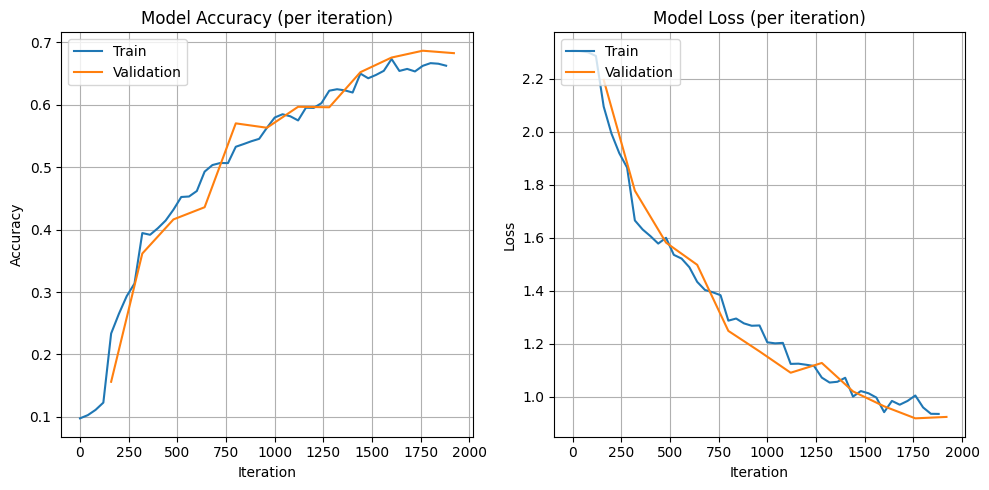

160/160 ━━━━━━━━━━━━━━━━━━━━ 142s 552ms/step - accuracy: 0.6637 - loss: 0.9700 - val_accuracy: 0.6828 - val_loss: 0.9249
Epoch 13/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.6801 - loss: 0.9009

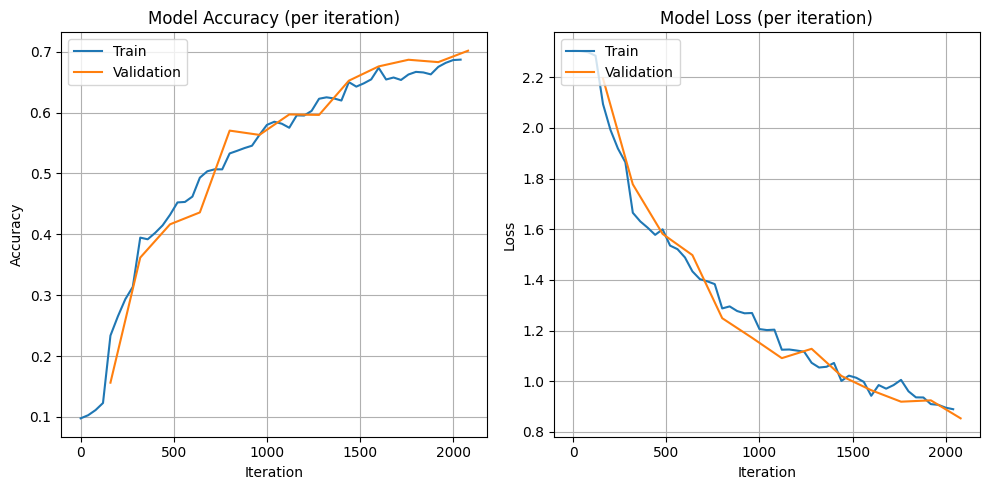

160/160 ━━━━━━━━━━━━━━━━━━━━ 142s 553ms/step - accuracy: 0.6801 - loss: 0.9008 - val_accuracy: 0.7016 - val_loss: 0.8538
Epoch 14/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.6806 - loss: 0.8886

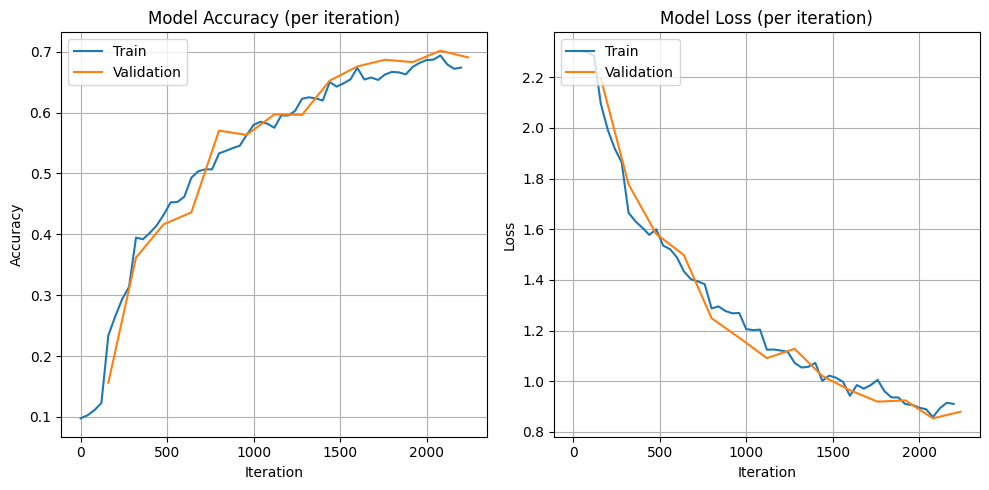

160/160 ━━━━━━━━━━━━━━━━━━━━ 142s 553ms/step - accuracy: 0.6805 - loss: 0.8888 - val_accuracy: 0.6906 - val_loss: 0.8800
Epoch 15/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.7075 - loss: 0.8475

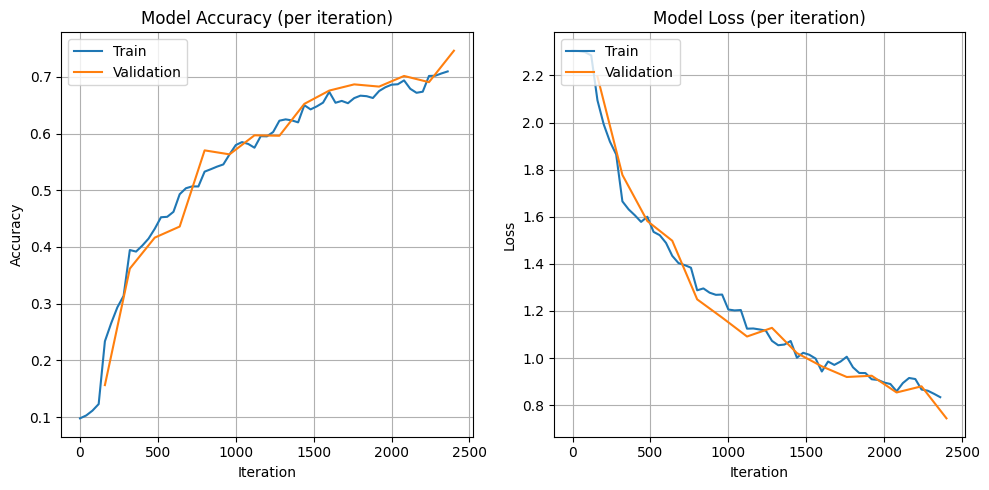

160/160 ━━━━━━━━━━━━━━━━━━━━ 141s 547ms/step - accuracy: 0.7075 - loss: 0.8474 - val_accuracy: 0.7461 - val_loss: 0.7440
Epoch 16/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7045 - loss: 0.8094

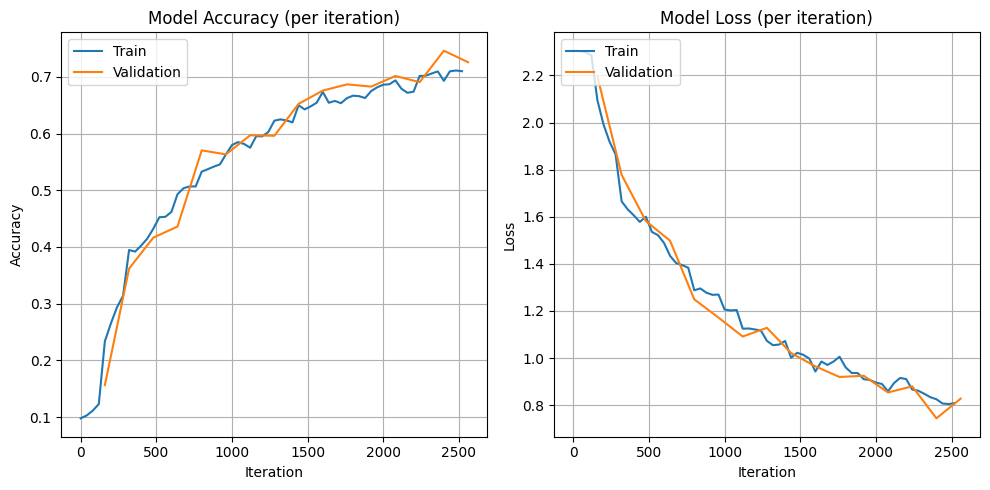

160/160 ━━━━━━━━━━━━━━━━━━━━ 143s 552ms/step - accuracy: 0.7046 - loss: 0.8094 - val_accuracy: 0.7258 - val_loss: 0.8276
Epoch 17/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.7160 - loss: 0.8075

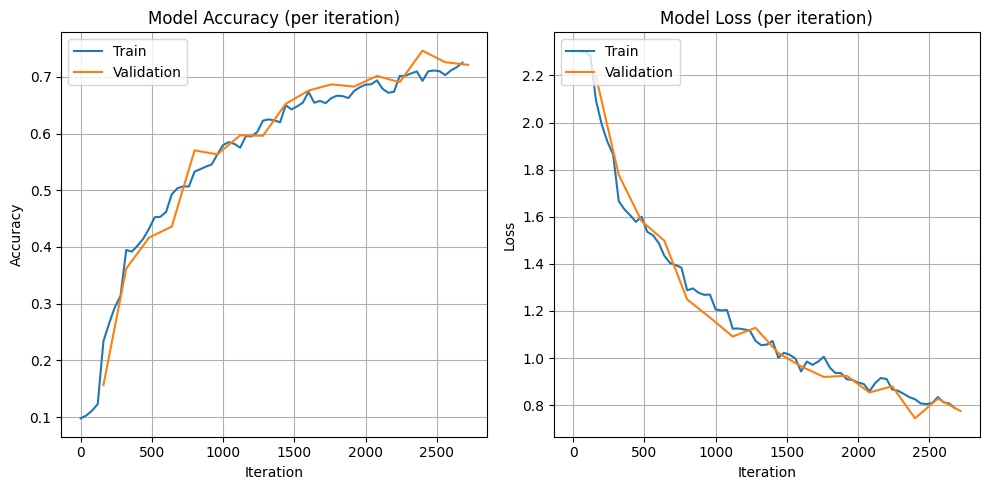

160/160 ━━━━━━━━━━━━━━━━━━━━ 142s 551ms/step - accuracy: 0.7161 - loss: 0.8073 - val_accuracy: 0.7211 - val_loss: 0.7749
Epoch 18/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.7361 - loss: 0.7594

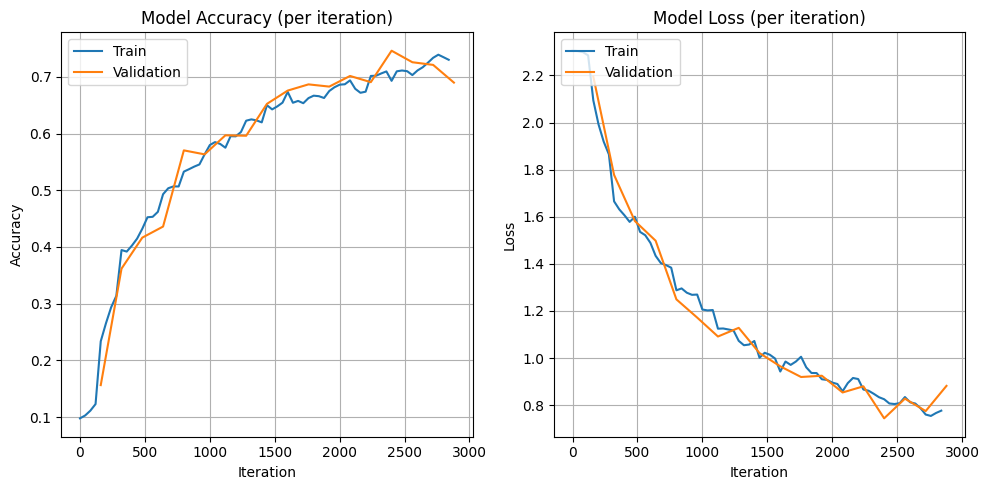

160/160 ━━━━━━━━━━━━━━━━━━━━ 89s 558ms/step - accuracy: 0.7360 - loss: 0.7595 - val_accuracy: 0.6898 - val_loss: 0.8818
Epoch 19/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.7496 - loss: 0.7240

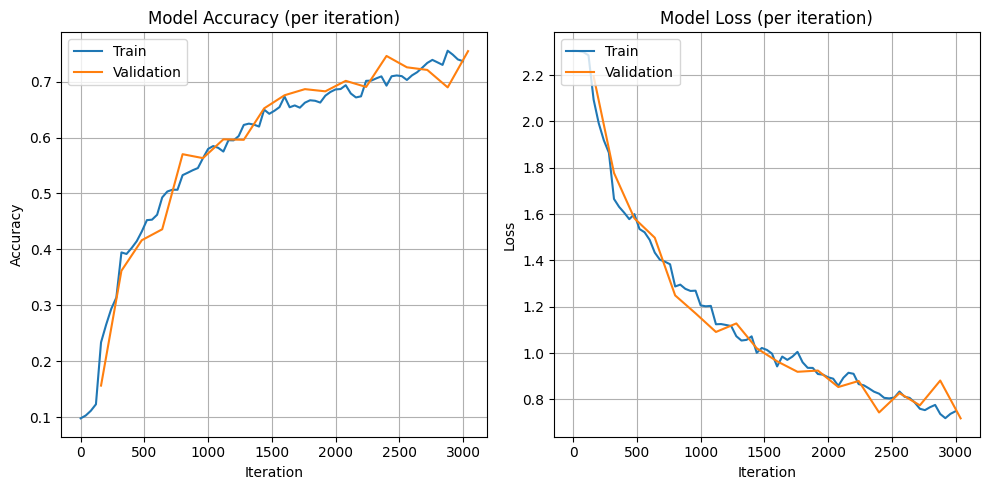

160/160 ━━━━━━━━━━━━━━━━━━━━ 89s 554ms/step - accuracy: 0.7495 - loss: 0.7241 - val_accuracy: 0.7547 - val_loss: 0.7187
Epoch 20/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7317 - loss: 0.7540

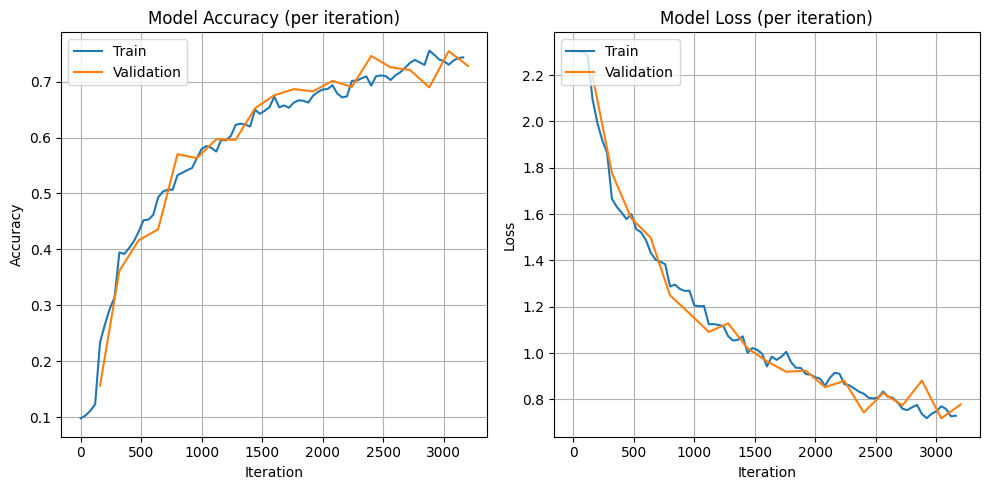

160/160 ━━━━━━━━━━━━━━━━━━━━ 90s 558ms/step - accuracy: 0.7317 - loss: 0.7539 - val_accuracy: 0.7281 - val_loss: 0.7784
Epoch 21/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7557 - loss: 0.7047

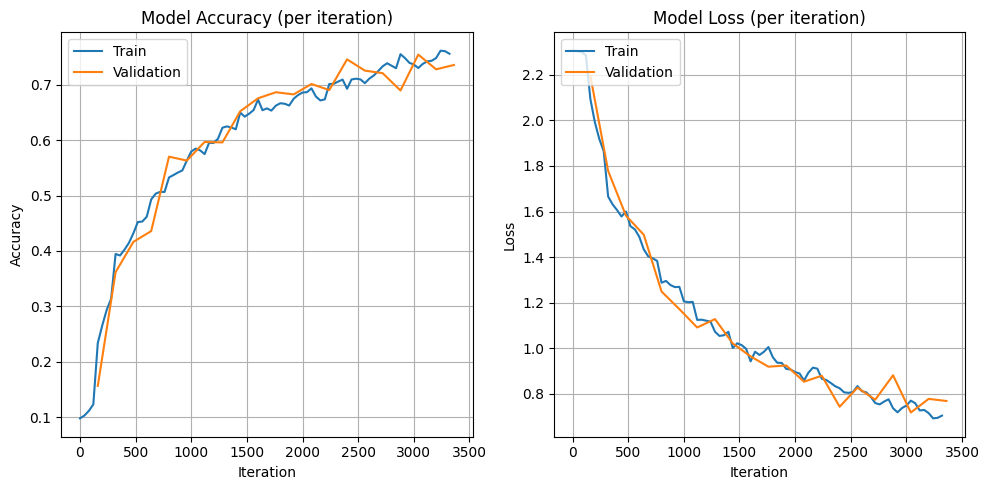

160/160 ━━━━━━━━━━━━━━━━━━━━ 88s 551ms/step - accuracy: 0.7557 - loss: 0.7047 - val_accuracy: 0.7359 - val_loss: 0.7691
Epoch 22/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.7520 - loss: 0.6996

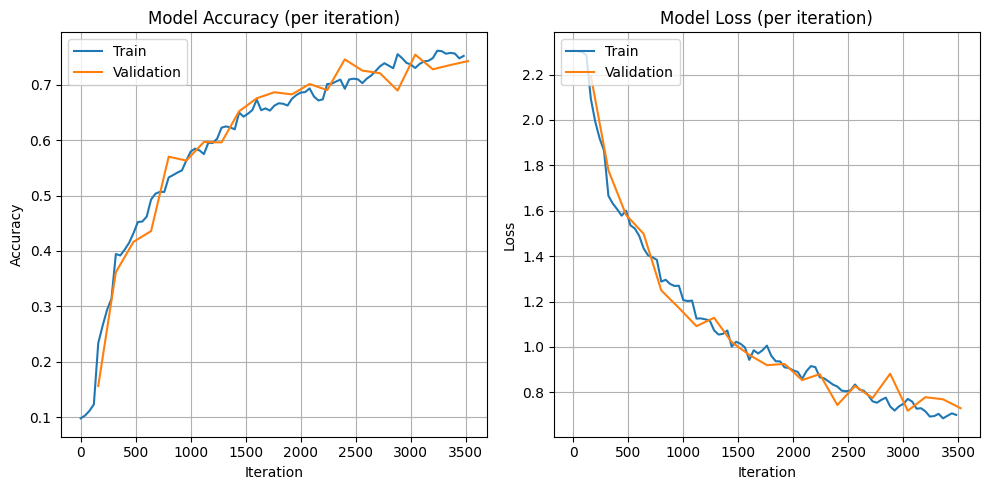

160/160 ━━━━━━━━━━━━━━━━━━━━ 89s 557ms/step - accuracy: 0.7520 - loss: 0.6996 - val_accuracy: 0.7430 - val_loss: 0.7299
Epoch 23/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7688 - loss: 0.6476

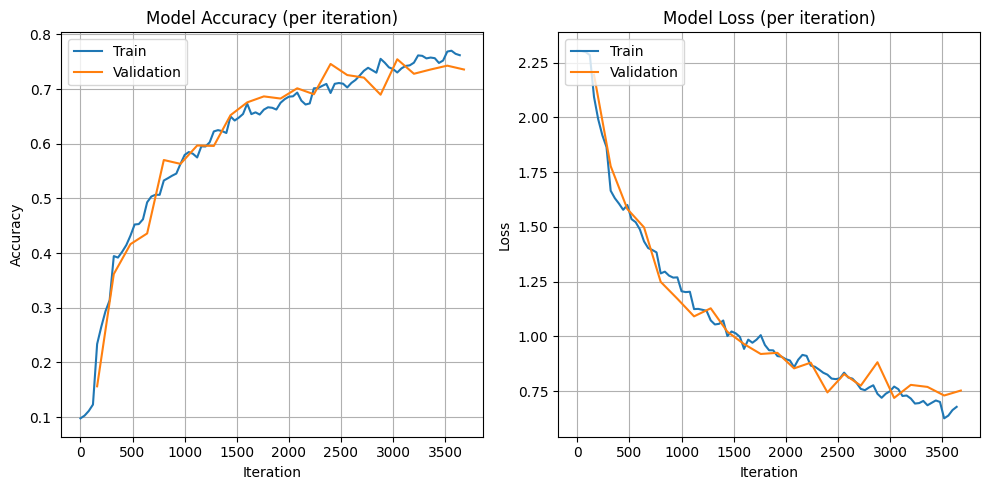

160/160 ━━━━━━━━━━━━━━━━━━━━ 88s 552ms/step - accuracy: 0.7688 - loss: 0.6478 - val_accuracy: 0.7359 - val_loss: 0.7525
Epoch 24/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.7712 - loss: 0.6542

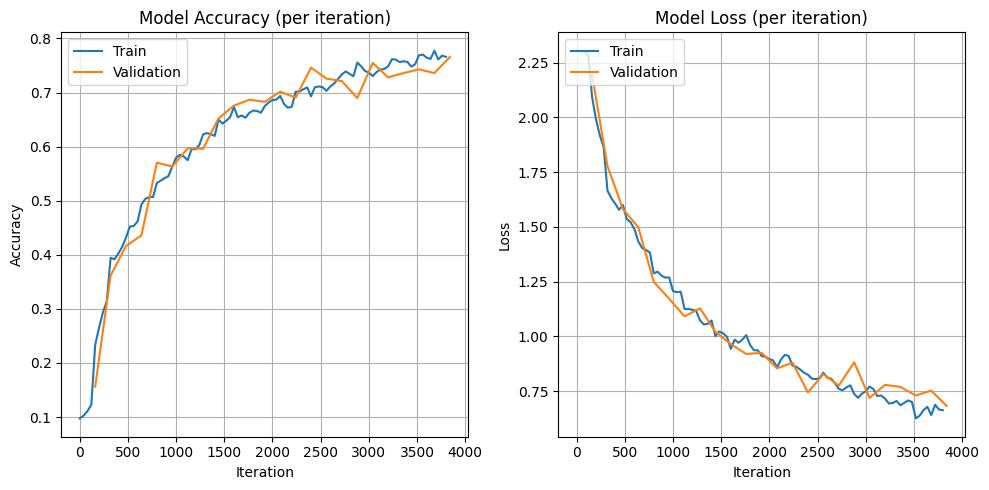

160/160 ━━━━━━━━━━━━━━━━━━━━ 95s 591ms/step - accuracy: 0.7711 - loss: 0.6542 - val_accuracy: 0.7656 - val_loss: 0.6822
Epoch 25/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.7720 - loss: 0.6481

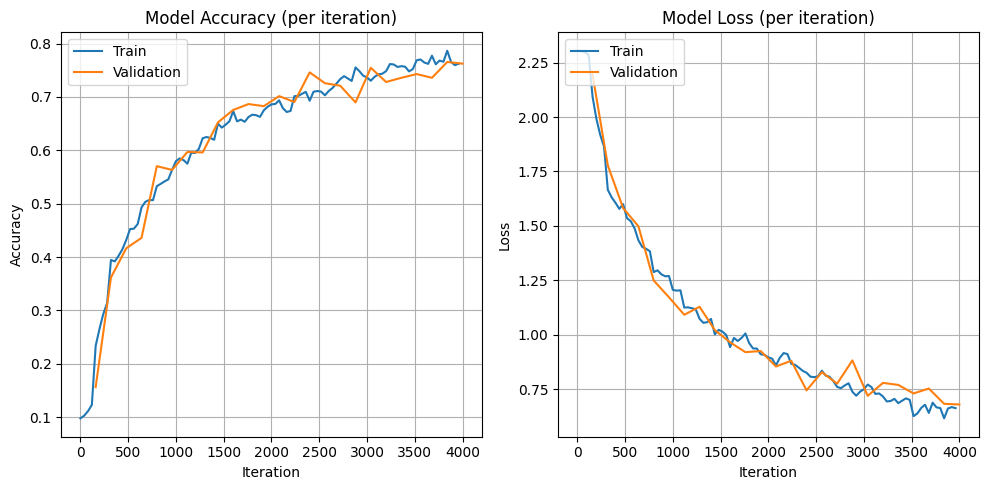

160/160 ━━━━━━━━━━━━━━━━━━━━ 89s 557ms/step - accuracy: 0.7719 - loss: 0.6482 - val_accuracy: 0.7625 - val_loss: 0.6791
Epoch 26/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.7690 - loss: 0.6282

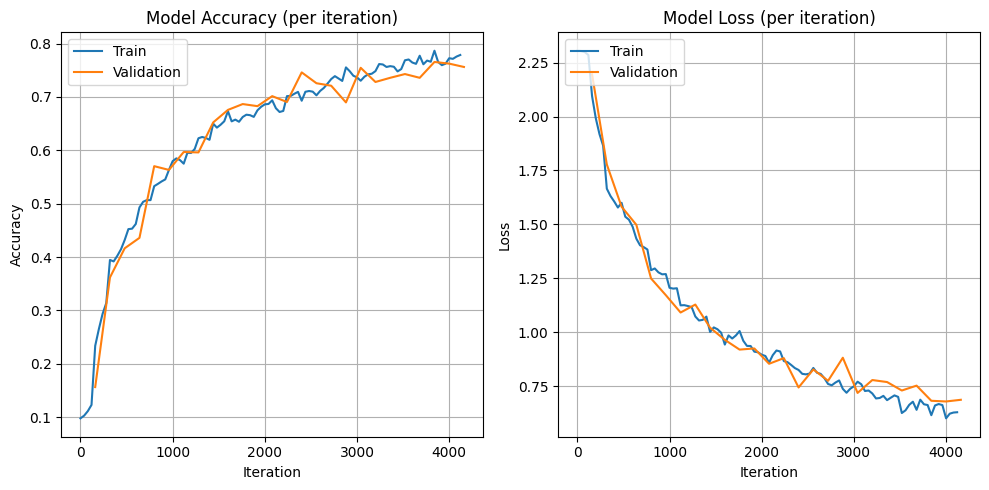

160/160 ━━━━━━━━━━━━━━━━━━━━ 141s 552ms/step - accuracy: 0.7691 - loss: 0.6282 - val_accuracy: 0.7563 - val_loss: 0.6869
Epoch 27/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step - accuracy: 0.8102 - loss: 0.5875

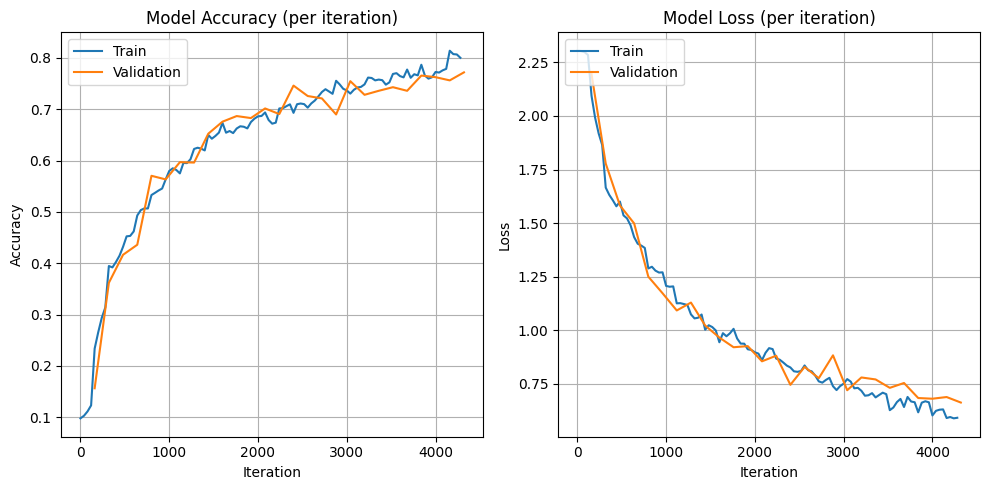

160/160 ━━━━━━━━━━━━━━━━━━━━ 89s 553ms/step - accuracy: 0.8102 - loss: 0.5875 - val_accuracy: 0.7719 - val_loss: 0.6612
Epoch 28/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.7998 - loss: 0.5737

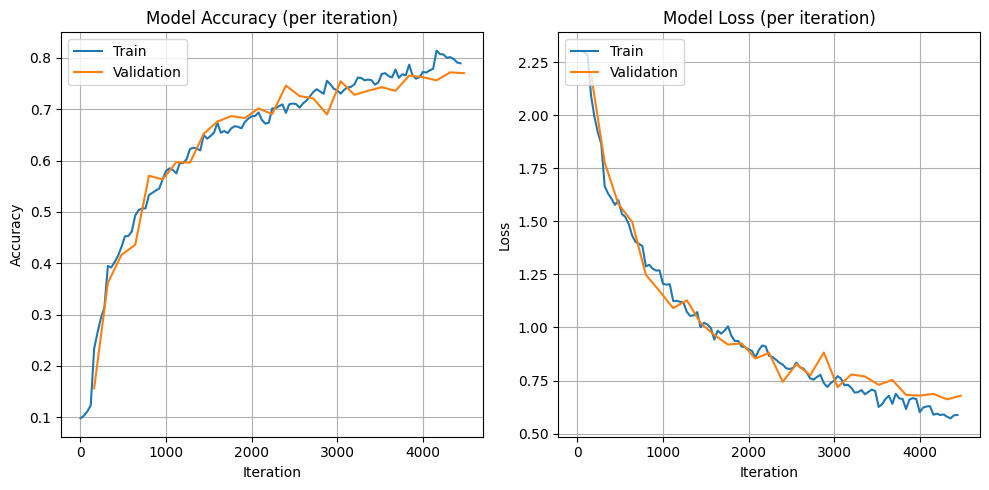

160/160 ━━━━━━━━━━━━━━━━━━━━ 90s 559ms/step - accuracy: 0.7997 - loss: 0.5738 - val_accuracy: 0.7703 - val_loss: 0.6785
Epoch 29/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.7958 - loss: 0.5811

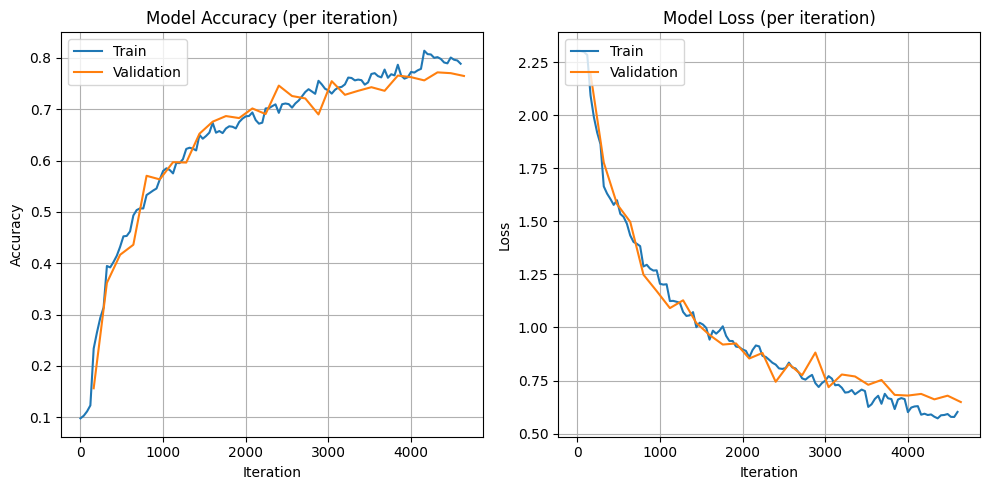

160/160 ━━━━━━━━━━━━━━━━━━━━ 89s 557ms/step - accuracy: 0.7957 - loss: 0.5812 - val_accuracy: 0.7648 - val_loss: 0.6485
Epoch 30/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8019 - loss: 0.5843

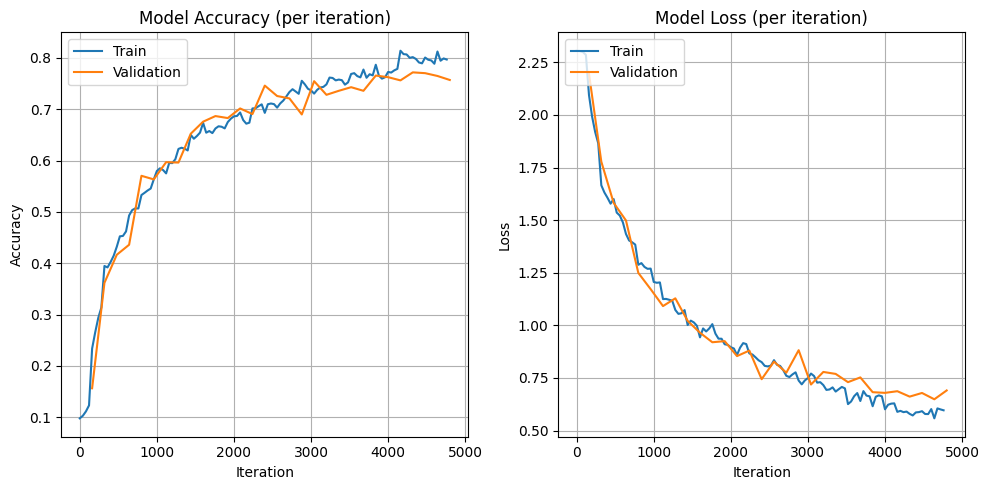

160/160 ━━━━━━━━━━━━━━━━━━━━ 143s 564ms/step - accuracy: 0.8019 - loss: 0.5843 - val_accuracy: 0.7570 - val_loss: 0.6905
Epoch 31/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.8131 - loss: 0.5488

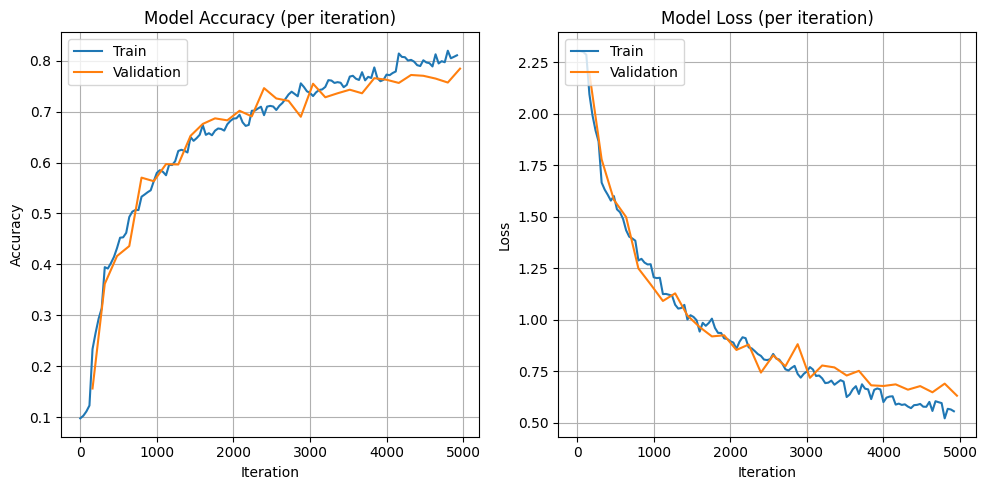

160/160 ━━━━━━━━━━━━━━━━━━━━ 146s 591ms/step - accuracy: 0.8131 - loss: 0.5488 - val_accuracy: 0.7844 - val_loss: 0.6320
Epoch 32/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.8209 - loss: 0.5166

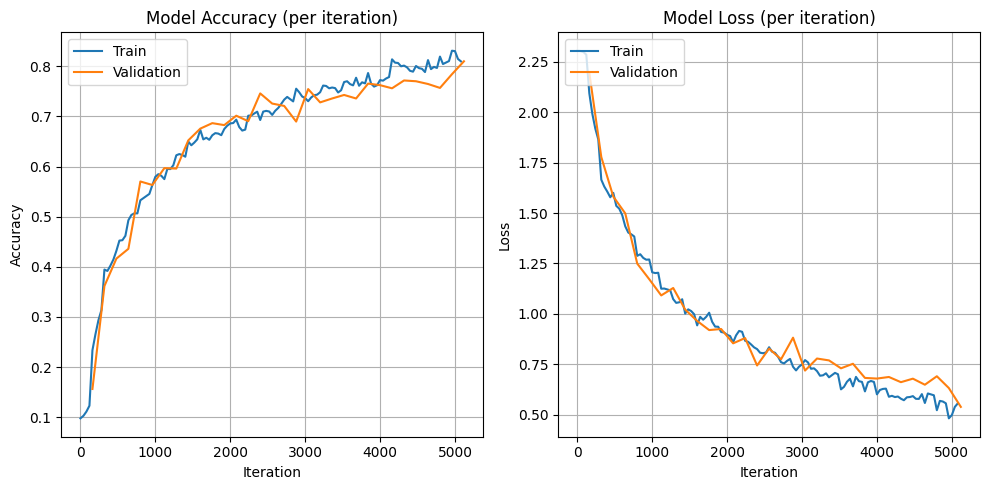

160/160 ━━━━━━━━━━━━━━━━━━━━ 89s 558ms/step - accuracy: 0.8208 - loss: 0.5169 - val_accuracy: 0.8102 - val_loss: 0.5386
Epoch 33/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - accuracy: 0.8113 - loss: 0.5254

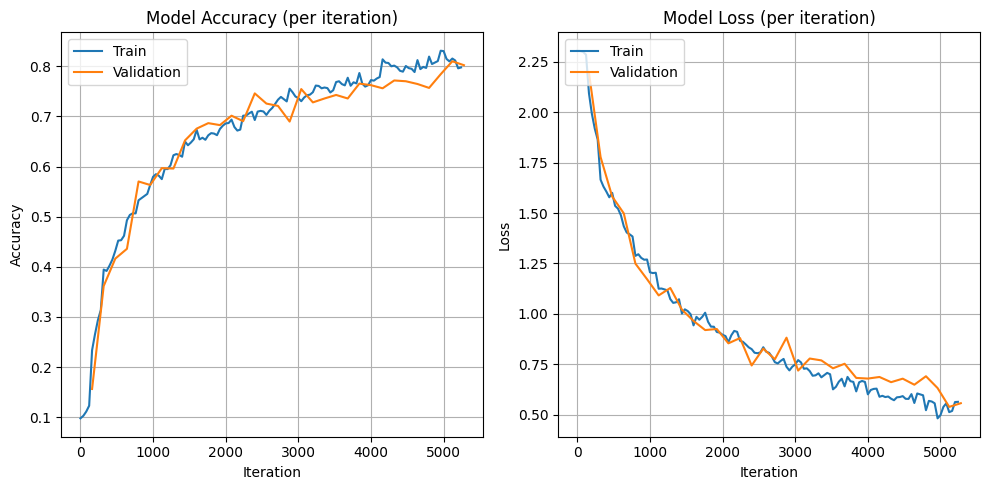

160/160 ━━━━━━━━━━━━━━━━━━━━ 141s 555ms/step - accuracy: 0.8112 - loss: 0.5257 - val_accuracy: 0.8023 - val_loss: 0.5568
Epoch 34/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.8094 - loss: 0.5430

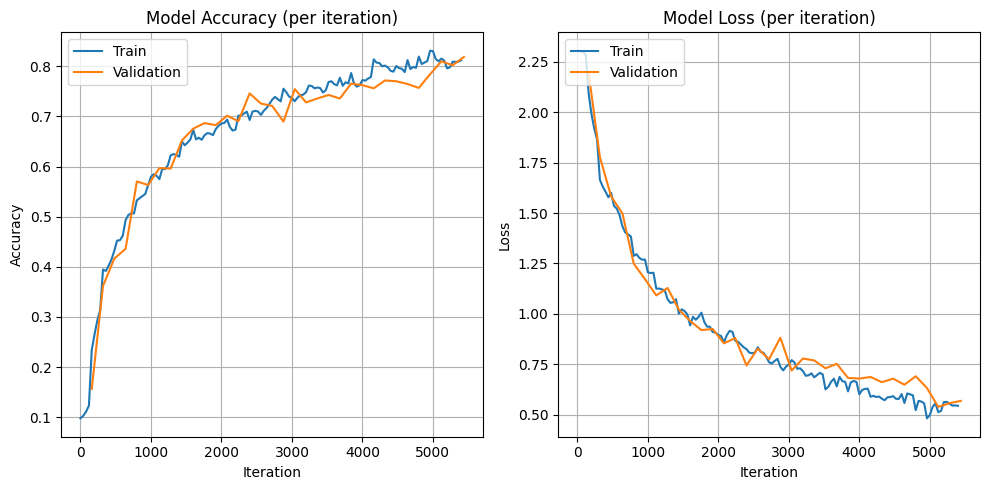

160/160 ━━━━━━━━━━━━━━━━━━━━ 143s 563ms/step - accuracy: 0.8095 - loss: 0.5430 - val_accuracy: 0.8188 - val_loss: 0.5683
Epoch 35/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - accuracy: 0.8118 - loss: 0.5162

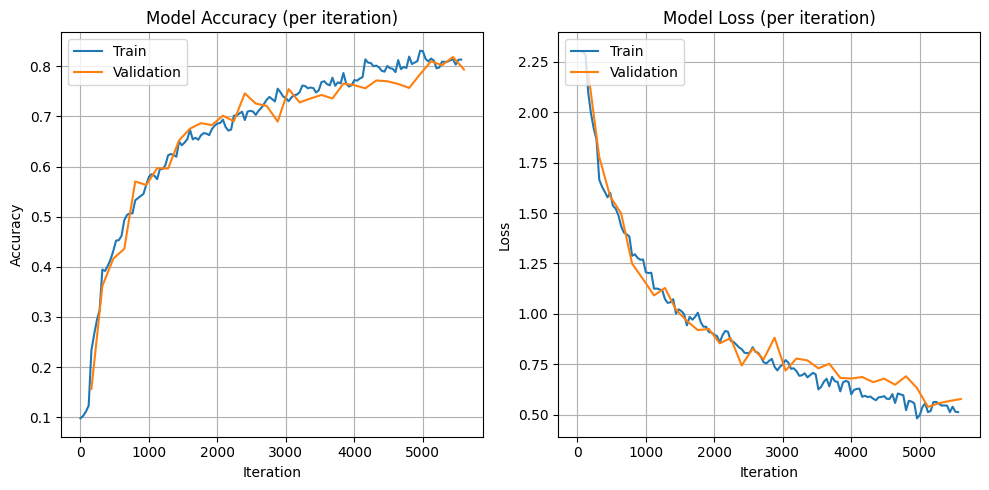

160/160 ━━━━━━━━━━━━━━━━━━━━ 95s 596ms/step - accuracy: 0.8118 - loss: 0.5162 - val_accuracy: 0.7937 - val_loss: 0.5774
Epoch 36/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.8119 - loss: 0.5260

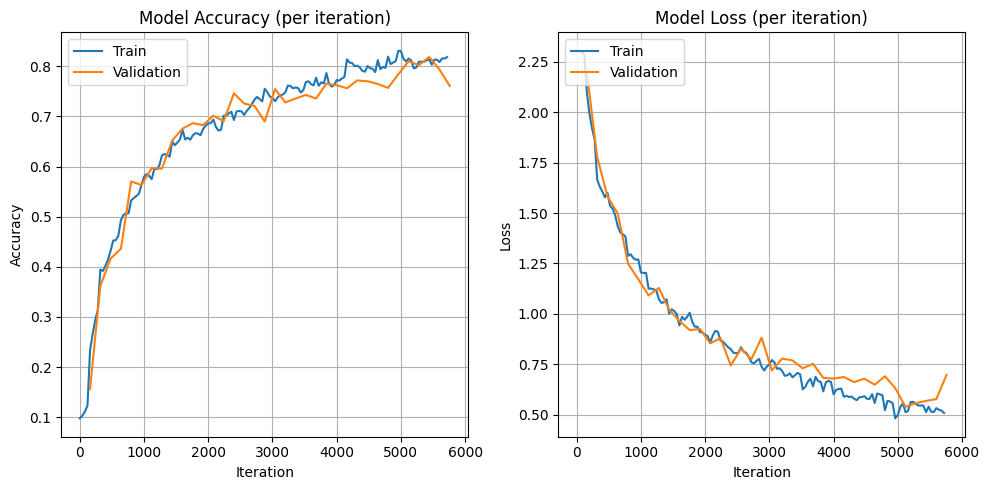

160/160 ━━━━━━━━━━━━━━━━━━━━ 136s 557ms/step - accuracy: 0.8119 - loss: 0.5259 - val_accuracy: 0.7609 - val_loss: 0.6977
Epoch 37/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.8203 - loss: 0.5061

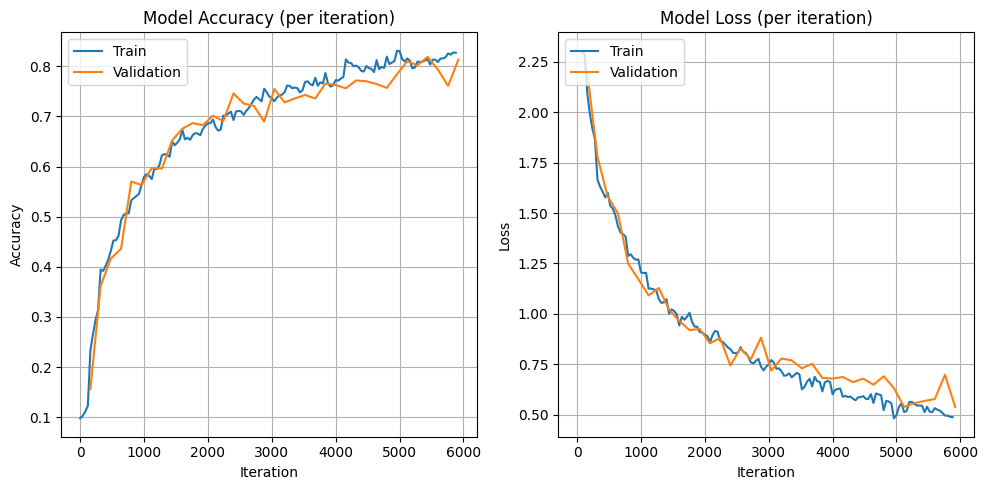

160/160 ━━━━━━━━━━━━━━━━━━━━ 149s 600ms/step - accuracy: 0.8204 - loss: 0.5060 - val_accuracy: 0.8133 - val_loss: 0.5382
Epoch 38/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8246 - loss: 0.4992

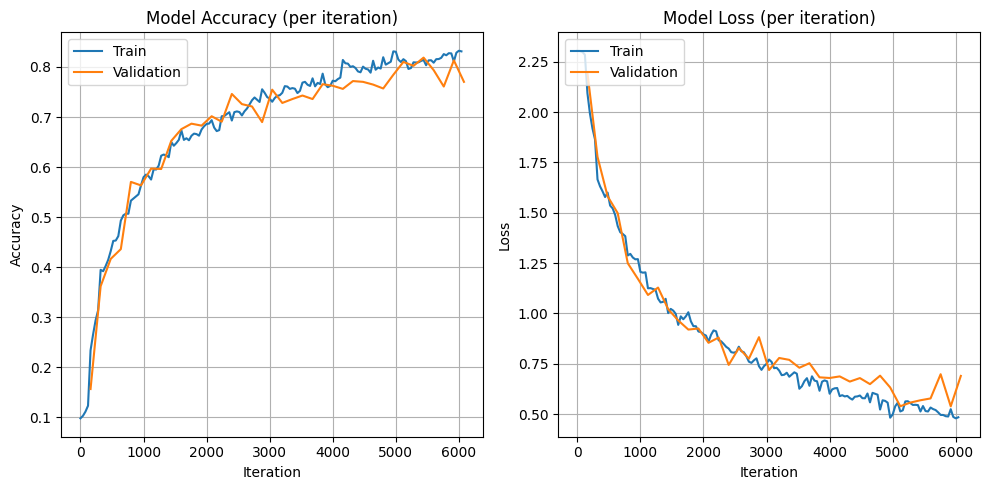

160/160 ━━━━━━━━━━━━━━━━━━━━ 136s 562ms/step - accuracy: 0.8246 - loss: 0.4991 - val_accuracy: 0.7703 - val_loss: 0.6893
Epoch 39/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8315 - loss: 0.4708

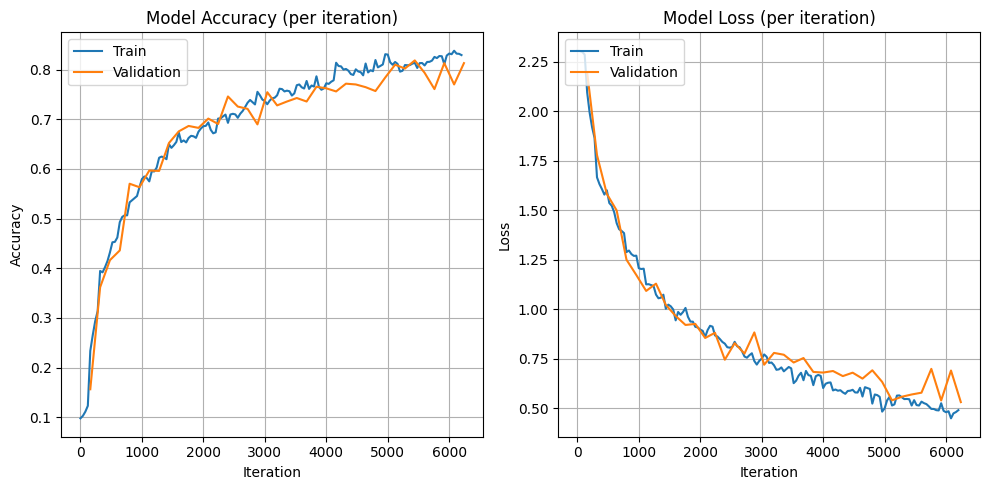

160/160 ━━━━━━━━━━━━━━━━━━━━ 91s 571ms/step - accuracy: 0.8315 - loss: 0.4709 - val_accuracy: 0.8133 - val_loss: 0.5298
Epoch 40/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.8280 - loss: 0.4971

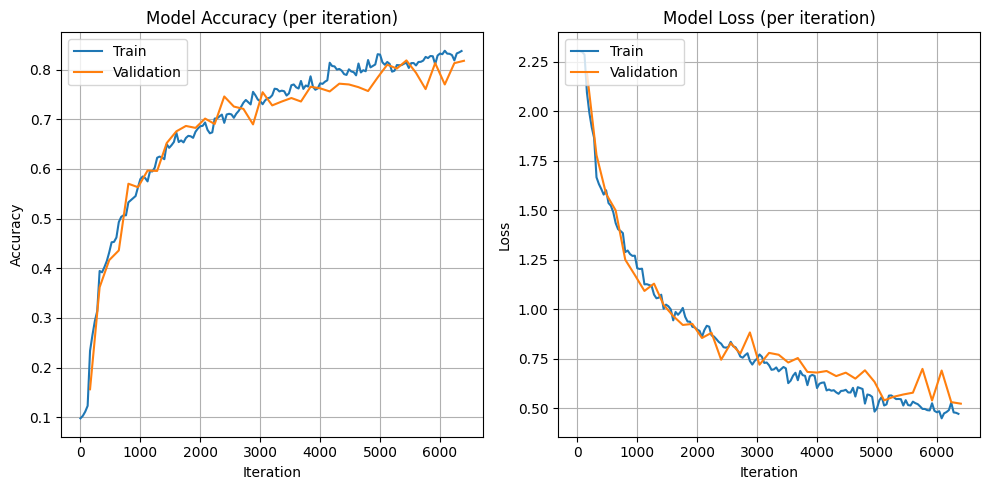

160/160 ━━━━━━━━━━━━━━━━━━━━ 141s 565ms/step - accuracy: 0.8280 - loss: 0.4969 - val_accuracy: 0.8180 - val_loss: 0.5219
Epoch 41/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8333 - loss: 0.4845

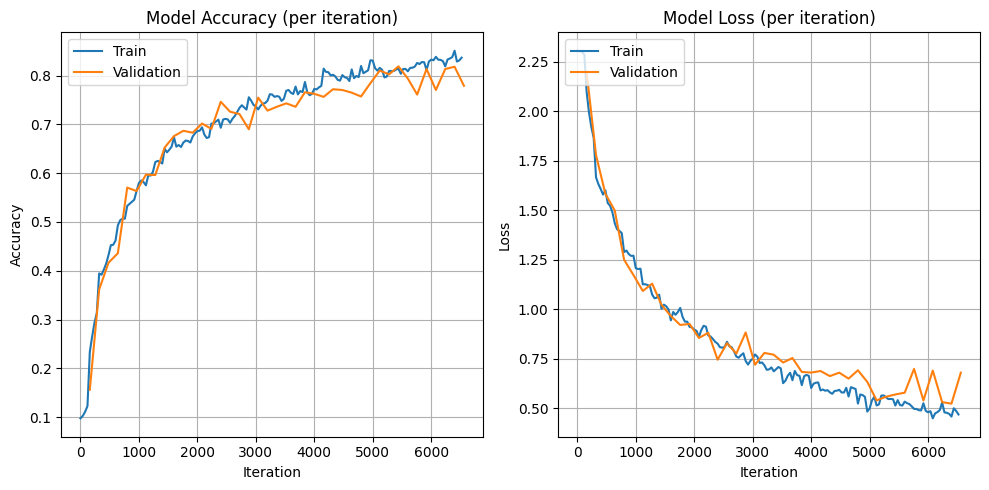

160/160 ━━━━━━━━━━━━━━━━━━━━ 91s 571ms/step - accuracy: 0.8333 - loss: 0.4844 - val_accuracy: 0.7789 - val_loss: 0.6784
Epoch 42/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8322 - loss: 0.4939

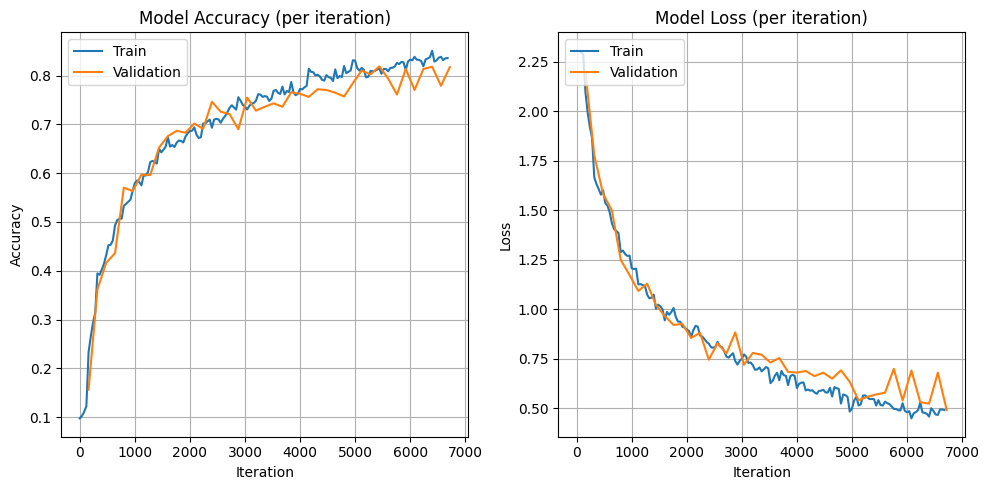

160/160 ━━━━━━━━━━━━━━━━━━━━ 90s 562ms/step - accuracy: 0.8322 - loss: 0.4939 - val_accuracy: 0.8172 - val_loss: 0.4901
Epoch 43/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8477 - loss: 0.4408

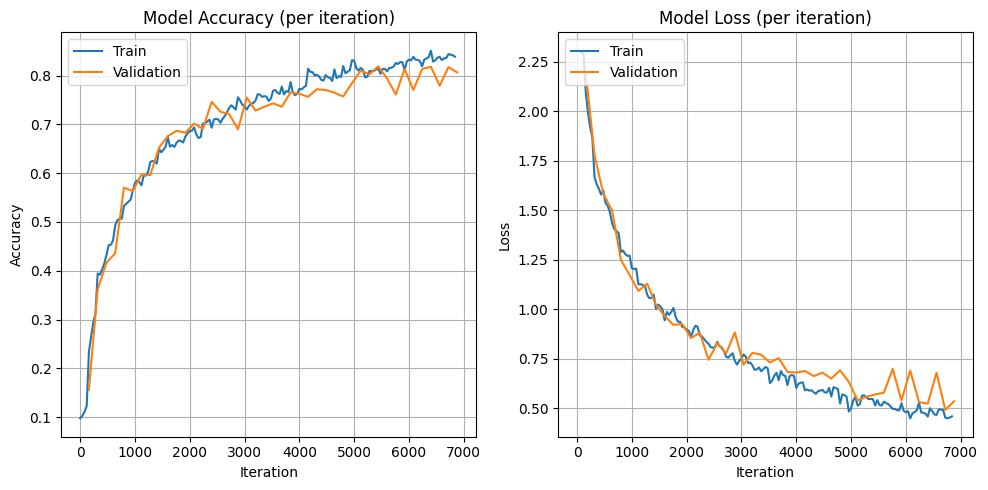

160/160 ━━━━━━━━━━━━━━━━━━━━ 143s 567ms/step - accuracy: 0.8476 - loss: 0.4409 - val_accuracy: 0.8062 - val_loss: 0.5340
Epoch 44/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.8524 - loss: 0.4326

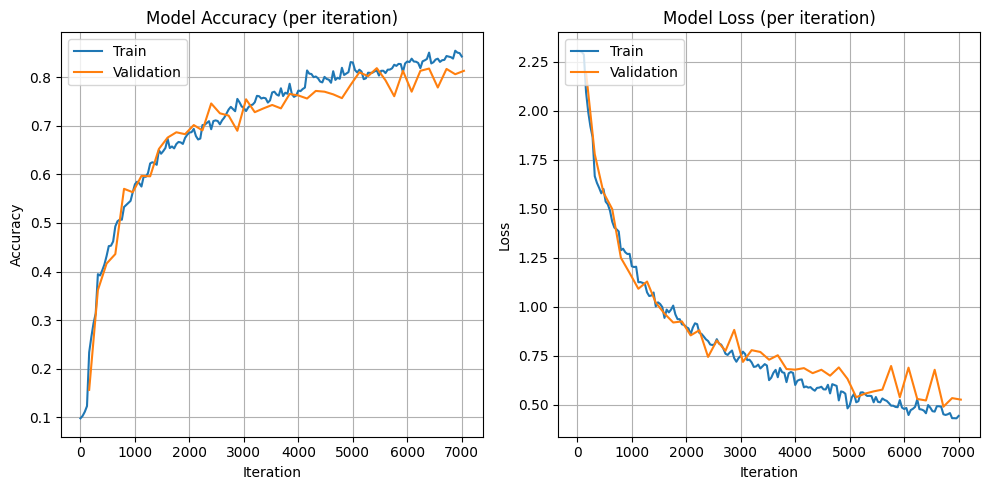

160/160 ━━━━━━━━━━━━━━━━━━━━ 142s 564ms/step - accuracy: 0.8523 - loss: 0.4327 - val_accuracy: 0.8133 - val_loss: 0.5263
Epoch 45/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8513 - loss: 0.4205

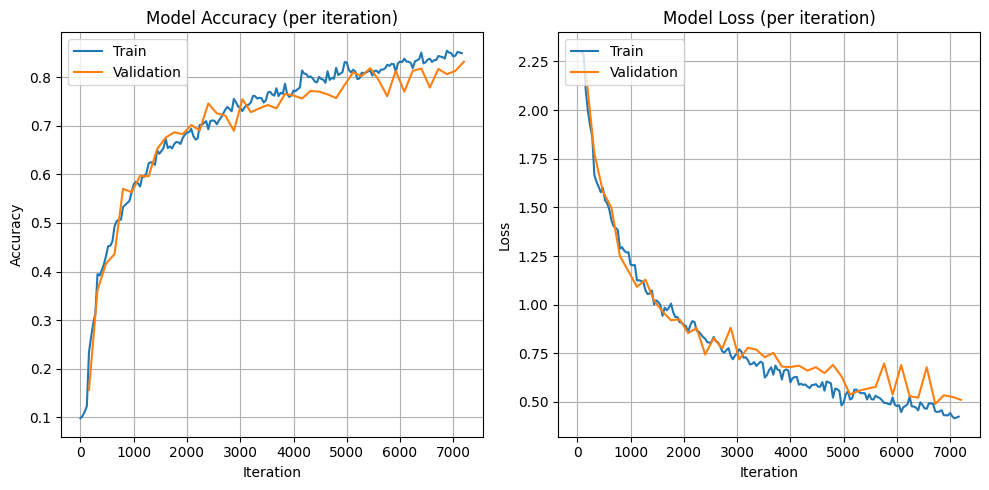

160/160 ━━━━━━━━━━━━━━━━━━━━ 90s 565ms/step - accuracy: 0.8513 - loss: 0.4205 - val_accuracy: 0.8320 - val_loss: 0.5110
Epoch 46/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8579 - loss: 0.4127

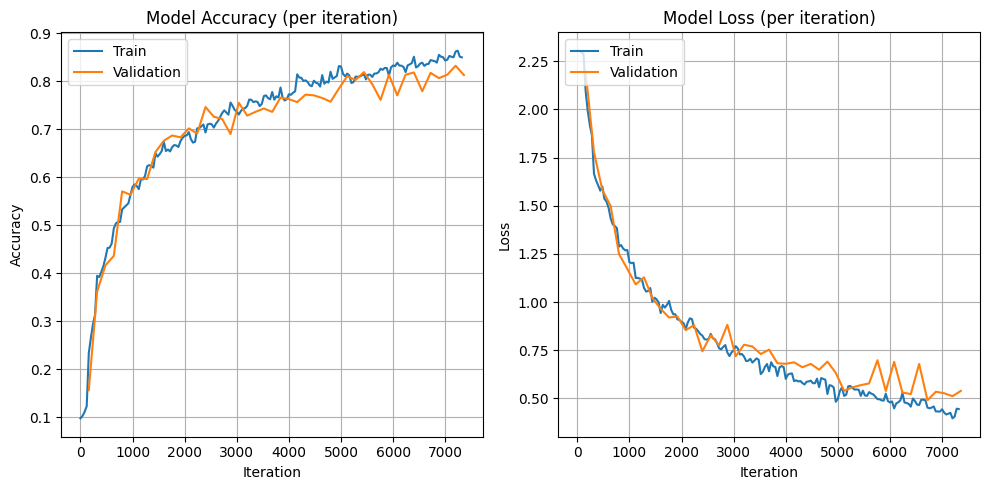

160/160 ━━━━━━━━━━━━━━━━━━━━ 91s 568ms/step - accuracy: 0.8578 - loss: 0.4129 - val_accuracy: 0.8125 - val_loss: 0.5384
Epoch 47/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.8380 - loss: 0.4571

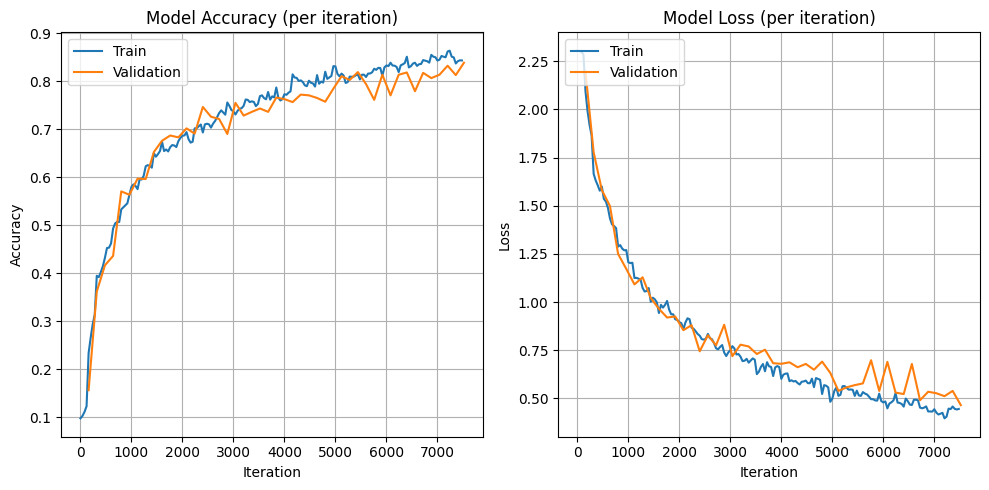

160/160 ━━━━━━━━━━━━━━━━━━━━ 142s 568ms/step - accuracy: 0.8380 - loss: 0.4570 - val_accuracy: 0.8383 - val_loss: 0.4645
Epoch 48/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.8691 - loss: 0.3946

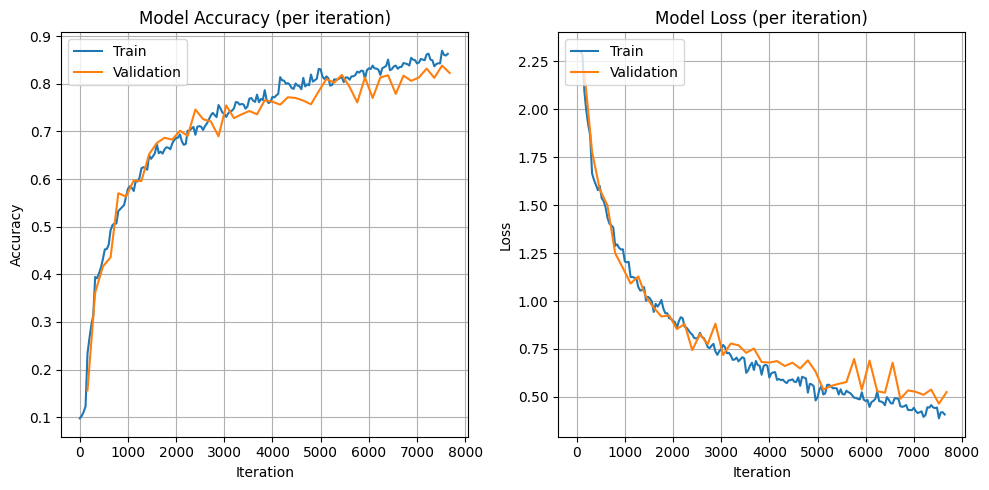

160/160 ━━━━━━━━━━━━━━━━━━━━ 92s 572ms/step - accuracy: 0.8691 - loss: 0.3947 - val_accuracy: 0.8227 - val_loss: 0.5253
Epoch 49/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.8508 - loss: 0.4231

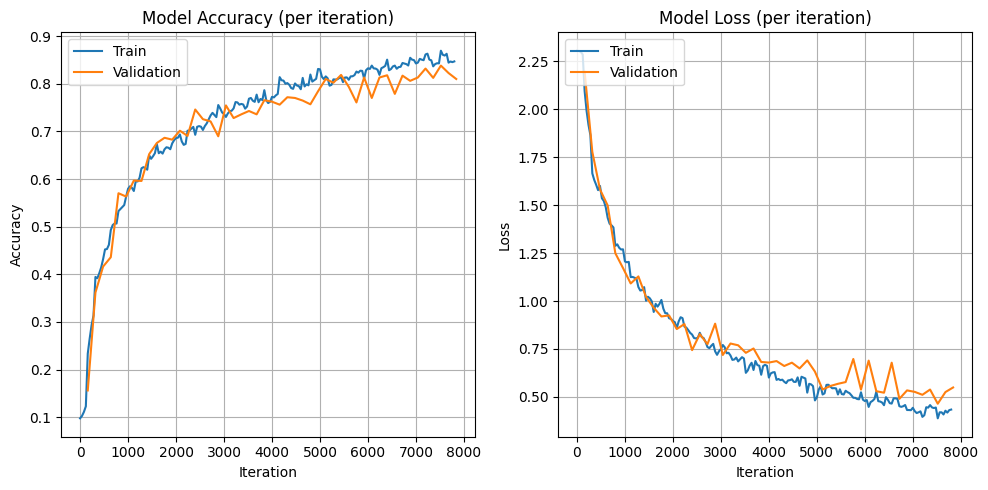

160/160 ━━━━━━━━━━━━━━━━━━━━ 142s 575ms/step - accuracy: 0.8508 - loss: 0.4232 - val_accuracy: 0.8102 - val_loss: 0.5492
Epoch 50/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.8551 - loss: 0.4323

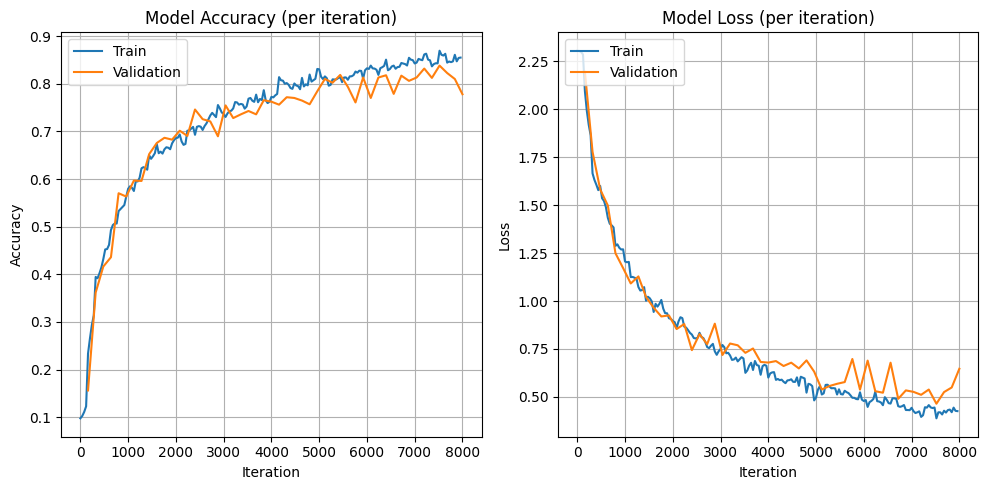

160/160 ━━━━━━━━━━━━━━━━━━━━ 91s 567ms/step - accuracy: 0.8551 - loss: 0.4322 - val_accuracy: 0.7781 - val_loss: 0.6467


In [22]:
# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator, validation_data=validation_generator, epochs=50, callbacks = [StopTrainingCallback(patience=5),plot_callback])

Found 1600 images belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.8067 - loss: 0.5764
Test Loss: 0.6370101571083069
Test Accuracy: 0.793749988079071
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step


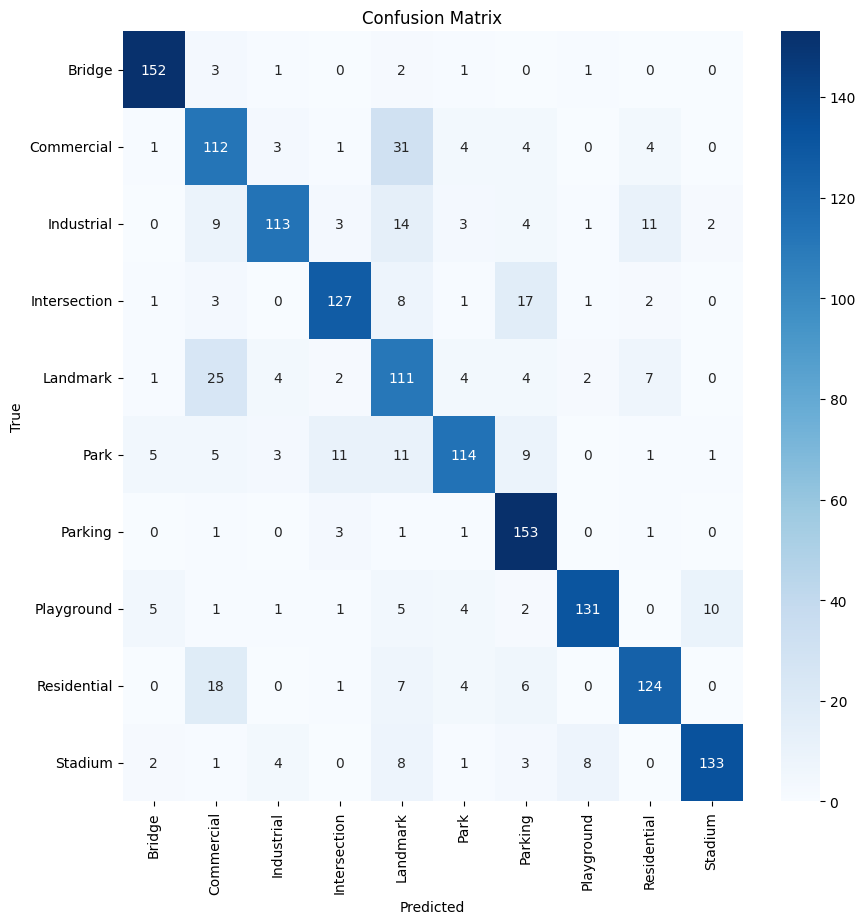

In [24]:
# Create an ImageDataGenerator for testing data without augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

# Create a generator for the test data
test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for consistent evaluation
)

# Evaluate the model on the test data
results = model.evaluate(test_generator)

# Print the results
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])

# Get predictions on the test data
predictions = model.predict(test_generator)

# Get predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = test_generator.classes

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 29.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


In [ ]:
import tensorflowjs as tfjs
import tensorflow as tf

# Save the model in TensorFlow.js format
tfjs.converters.save_keras_model(model, 'tfjs_model')

# Convert and save the model in TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


# Save the model for TensorFlow Serving
# Create a directory for the saved model
import os
model_version = 1
export_path = os.path.join('serving_model', str(model_version))
print('export_path = {}\n'.format(export_path))

if os.path.isdir(export_path):
    print('\nAlready saved a model, cleaning up\n')
    !rm -r {export_path}

tf.saved_model.save(model, export_path)
print('\nSaved model:')
!ls -l {export_path}


failed to lookup keras version from the file,
    this is likely a weight only file
Saved artifact at '/tmp/tmpge7qoakf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  139191219732304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139191219731344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139191219727120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139191188192336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139191188193104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139191188488848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139191188490000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139191188489424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139191188489040: TensorSpec(shape=(), dtype=tf.resource, name=None)

In [ ]:
# prompt: gunakan salah satu model yang disimpan untuk menguji suatu gambar dari luar

import tensorflow as tf
import numpy as np
from PIL import Image

# Load the saved model
model = tf.keras.models.load_model('serving_model/1') # Replace with the actual path

# Preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Path to the image you want to test
image_path = '/content/image_to_test.jpg' # Replace with the actual path

# Preprocess the image
preprocessed_image = preprocess_image(image_path)


# Make predictions
predictions = model.predict(preprocessed_image)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Print the prediction
print(f"Predicted class: {predicted_class}")
# You might need to map the predicted_class index to the actual class label.
# This depends on how your labels were encoded when training the model.
# For example:
# class_labels = ['class_1', 'class_2', 'class_3']
# print(f"Predicted class: {class_labels[predicted_class]}")


ValueError: File format not supported: filepath=serving_model/1. Keras 3 only supports V3 `.keras` files and legacy H5 format files (`.h5` extension). Note that the legacy SavedModel format is not supported by `load_model()` in Keras 3. In order to reload a TensorFlow SavedModel as an inference-only layer in Keras 3, use `keras.layers.TFSMLayer(serving_model/1, call_endpoint='serving_default')` (note that your `call_endpoint` might have a different name).

In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the saved model using tf.saved_model.load
model = tf.saved_model.load('serving_model/1')

# Preprocess the image
def preprocess_image(image_path):
    img = Image.open(image_path).resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Path to the image you want to test
image_path = '/content/image_to_test.jpg' # Replace with the actual path

# Preprocess the image
preprocessed_image = preprocess_image(image_path)


# Make predictions
predictions = model.predict(preprocessed_image)

# Get the predicted class
predicted_class = np.argmax(predictions)

# Print the prediction
print(f"Predicted class: {predicted_class}")
# You might need to map the predicted_class index to the actual class label.
# This depends on how your labels were encoded when training the model.
# For example:
# class_labels = ['class_1', 'class_2', 'class_3']
# print(f"Predicted class: {class_labels[predicted_class]}")
